## Run Network
Script for using existing network to run on cohort data

In [1]:
import os
import numpy as np
from deepcell import model_zoo
import matplotlib.pyplot as plt
import xarray as xr
import math

In [4]:
# load data
data_dir = '/data/shirley/test_points/big_test/'
cohort_xr = xr.load_dataarray(data_dir + 'Deepcell_Input_Big_Test.nc')

In [5]:
cohort_xr.channels

<xarray.DataArray 'channels' (channels: 6)>
array(['H3', 'VIM', 'HLAG', 'CD3', 'CD14', 'CD56'], dtype=object)
Coordinates:
  * channels  (channels) object 'H3' 'VIM' 'HLAG' 'CD3' 'CD14' 'CD56'

In [25]:
# load model
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = 'Decidua_Caliban_V3_test_convolutional_61_rf_512_dense_128_conv_epoch3.h5'
weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [37]:
run_conv_model = model_zoo.bn_feature_net_skip_2D(
    n_skips=3,
    fgbg_model=None,
    n_dense_filters=512,
    n_conv_filters=128,
    n_features=3,
    norm_method='std',
    receptive_field=61,
    last_only=False,
    n_channels=1,    
    input_shape=(1124, 1124, 6))


run_conv_model.load_weights(weights_path)

In [38]:
output_array = np.zeros((cohort_xr.shape[:3] + (3,)), dtype='float32')

In [39]:
# can't load entire image at once into memory, subset into slightly overlapping regions and run through
for i in range(cohort_xr[:10].shape[0]):
    print("predicting point {}".format(i))
    output_array[i, :1024, :1024, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), :1124, :1124, :])[-1][:, :1024, :1024, :]
    output_array[i, :1024, 1024:, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), :1124, 924:, :])[-1][:, :1024, 100:, :]
    output_array[i, 1024:, :1024, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), 924:, :1124, :])[-1][:, 100:, :1024, :]
    output_array[i, 1024:, 1024:, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), 924:, 924:, :])[-1][:, 100:, 100:, :]
    output_array[i, 1024:, 1024:, :] = run_conv_model.predict(cohort_xr.values[i:(i + 1), 924:, 924:, :])[-1][:, 100:, 100:, :]
    

predicting point 0
predicting point 1
predicting point 2
predicting point 3
predicting point 4
predicting point 5
predicting point 6
predicting point 7
predicting point 8
predicting point 9


In [40]:
output_array = output_array * 127
output_array = output_array.astype('int8')

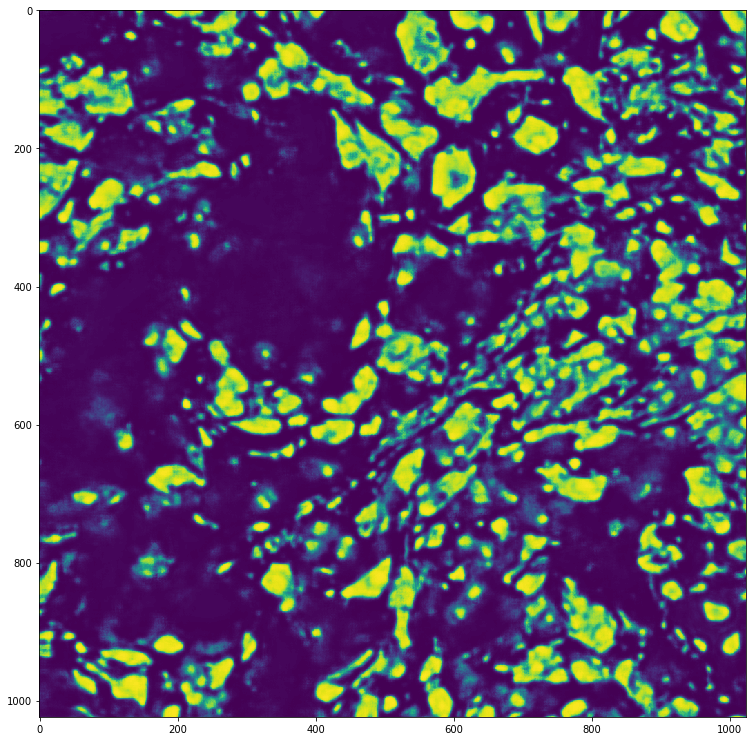

In [41]:
plt.figure(figsize = (13, 13))
plt.imshow(output_array[7, :1024, :1024, 1])

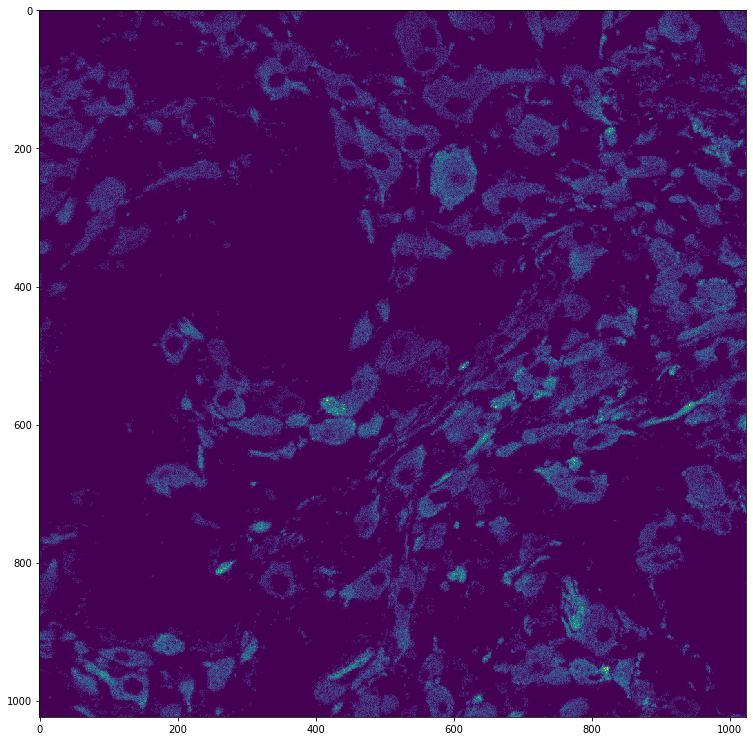

In [45]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[7, :1024, :1024, 1])

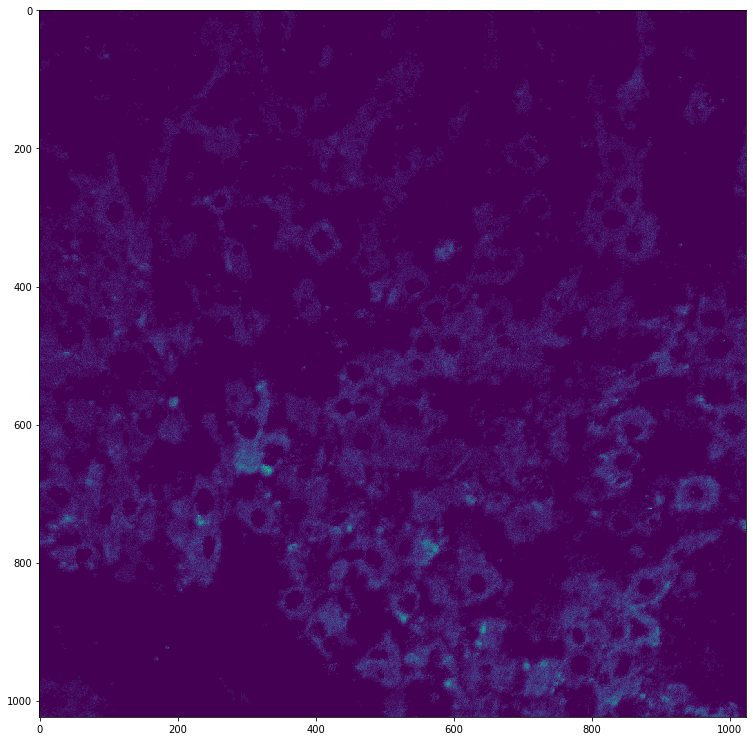

In [68]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr.values[6, :1024, :1024, 2])

In [18]:
xr_output = xr.DataArray(output_array,
                         coords=[cohort_xr.coords['points'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), ['border', 'interior', 'bg']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join(data_dir, "20191214_Decidua_Caliban_V1_deepcell_output_pixel.nc"), format="NETCDF3_64BIT")


# Run watershed network

In [19]:
experiment_folder = "20191113_Decidua_Shirley_Relabel"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
MODEL_NAME = '20191214_Decidua_Caliban_V1_convolutional_watershed_101_rf_256_dense_64_conv.h5'
watershed_weights_path = os.path.join(MODEL_DIR, MODEL_NAME)

In [20]:
run_watershed_model = model_zoo.bn_feature_net_skip_2D(
    n_skips=3,
    fgbg_model=None,
    n_dense_filters=256,
    n_conv_filters=64,
    n_features=4,
    norm_method='std',
    receptive_field=101,
    last_only=False,
    n_channels=1,    
    input_shape=(1124, 1124, 6))

run_watershed_model.load_weights(watershed_weights_path)

In [21]:
output_array_watershed = np.zeros((cohort_xr.shape[:3] + (4,)))

In [22]:
# can't load entire image at once into memory, subset into slightly overlapping regions and run through
for i in range(cohort_xr.shape[0]):
    print("predicting point {}".format(i))
    output_array_watershed[i, :1024, :1024, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), :1124, :1124, :])[-1][:, :1024, :1024, :]
    output_array_watershed[i, :1024, 1024:, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), :1124, 924:, :])[-1][:, :1024, 100:, :]
    output_array_watershed[i, 1024:, :1024, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), 924:, :1124, :])[-1][:, 100:, :1024, :]
    output_array_watershed[i, 1024:, 1024:, :] = run_watershed_model.predict(cohort_xr.values[i:(i + 1), 924:, 924:, :])[-1][:, 100:, 100:, :]
    

predicting point 0
predicting point 1
predicting point 2
predicting point 3
predicting point 4
predicting point 5
predicting point 6
predicting point 7
predicting point 8
predicting point 9
predicting point 10
predicting point 11


In [23]:
argmax_images = []
for j in range(output_array_watershed.shape[0]):
    argmax_images.append(np.argmax(output_array_watershed[j, ...], axis=-1))
argmax_images = np.array(argmax_images)

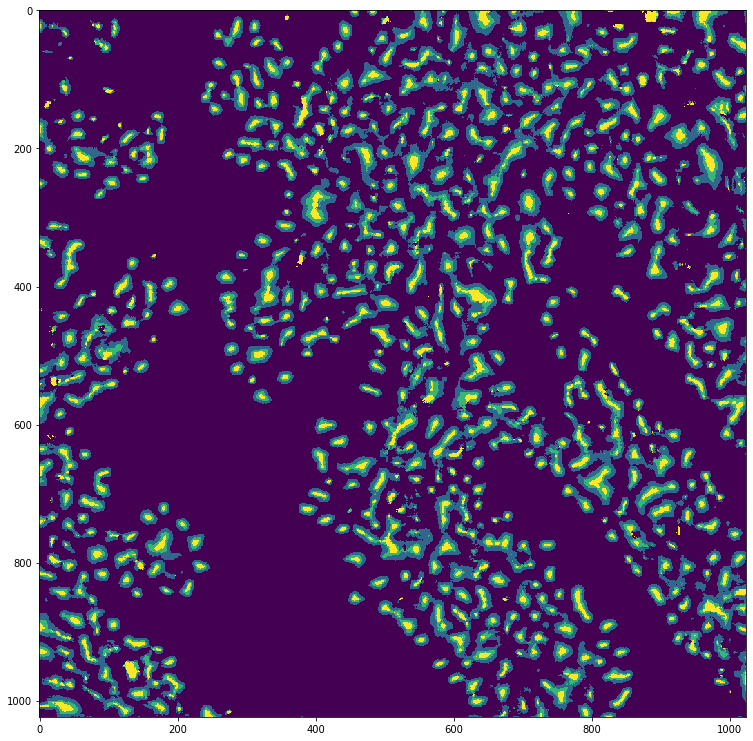

In [24]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :1024, :1024])

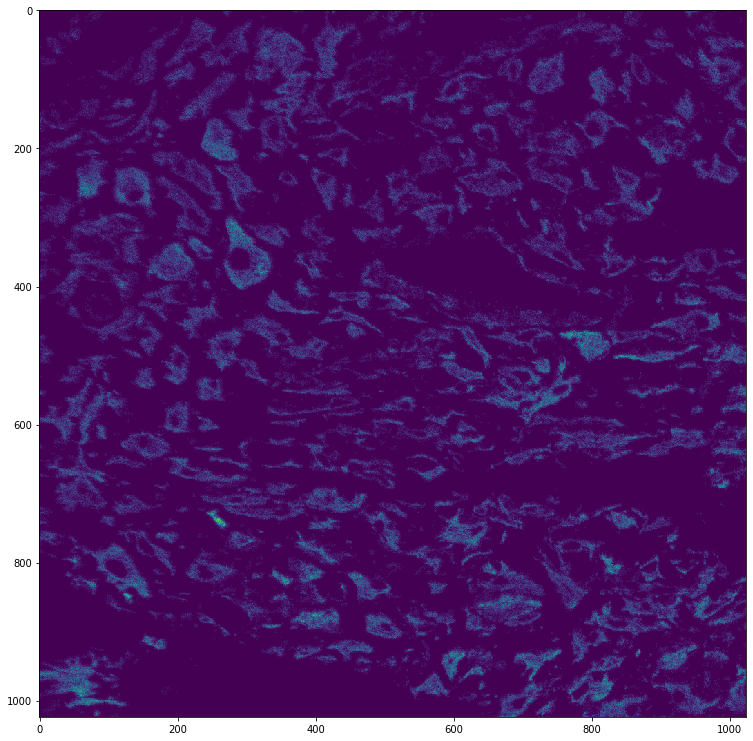

In [13]:
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[29, :1024, :1024, 1])

In [25]:
xr_output_watershed = xr.DataArray(np.expand_dims(argmax_images, axis=-1),
                         coords=[cohort_xr.coords['points'], range(argmax_images.shape[1]), 
                                 range(argmax_images.shape[2]), ['watershed_argmax']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output_watershed.to_netcdf(os.path.join(data_dir, "20191214_Decidua_Caliban_V1_deepcell_output_watershed.nc"), format="NETCDF3_64BIT")